In [1]:
# !pip3 install seaborn --user
# !pip3 install --index-url  http://pyrrepo.int.cdphp.com/pypi/simple --trusted-host pyrrepo.int.cdphp.com --user pyarrow
# !pip3 install lifelines --user
# !pip3 install pandas --upgrade --user
# !pip3 install pyspark --user
# !pip3 install tqdm --user
# !pip3 install cython --user
# !pip3 install dowhy --user
# !pip3 install rpy2 --user
# !pip3 install scikit-learn --user --upgrade --index-url https://nexus.int.cdphp.com/repository/pypi-all/simple --trusted-host nexus.int.cdphp.com 

In [2]:
# #setup cython
# #for cython build if needed -> cd to /modules folder and then run
# %cd ../../modules
# !python3 ./setup.py build_ext --inplace
# %cd ../notebooks/experiments

### Survival Analysis

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [3]:
import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

import sys
warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from pathlib import Path
sys.path.append(str(Path.home()) + '/rpi-canary-eval/modules')
from diabetes_onset import survival_diabetes
import boto3

In [4]:
onset="CC_DIABETES"

### Pull data from S3

In [5]:
keys = ["treated0_o.p", "treated1_o.p", "random_o.p", "match0_o.p", "match1_o.p"]
s3 = boto3.client('s3')
bucket = 'cdphp-s3-us-e-p-pond'
aws_path = "rpi/nneehal/DATA/odata/metabolic/"
local_path = str(Path.home()) + '/rpi-canary-eval/temp/odata/'
for key in keys:
    s3.download_file(bucket, aws_path + key, local_path + key)

#### Get the following datasets from running ```diabetes_surv_propens5.ipynb```

In [6]:
%%time
treated0 = pd.read_pickle(local_path+'treated0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
treated1 = pd.read_pickle(local_path+'treated1_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
random =  pd.read_pickle(local_path+'random_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
control0 = pd.read_pickle(local_path+'match0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
control1 = pd.read_pickle(local_path+'match1_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)


CPU times: user 1.52 s, sys: 1.56 s, total: 3.08 s
Wall time: 3.09 s


In [7]:
treated0.shape, control0.shape, treated1.shape, control1.shape, random.shape

In [8]:
%%time
surv1 = treated0.groupby('PERS_ID').apply(survival_diabetes, onset=onset).reset_index(drop = True)
surv2 = treated1.groupby('PERS_ID').apply(survival_diabetes, onset=onset).reset_index(drop = True)

CPU times: user 2.89 s, sys: 0 ns, total: 2.89 s
Wall time: 2.89 s


In [9]:
%%time
surv3 = control0.groupby('PERS_ID').apply(survival_diabetes, onset=onset).reset_index(drop = True)
surv4 = control1.groupby('PERS_ID').apply(survival_diabetes, onset=onset).reset_index(drop = True)

CPU times: user 53.1 s, sys: 0 ns, total: 53.1 s
Wall time: 53.1 s


In [10]:
%%time
surv5 = random.groupby('PERS_ID').apply(survival_diabetes, onset=onset).reset_index(drop = True)

CPU times: user 3min 29s, sys: 1.39 s, total: 3min 30s
Wall time: 3min 30s


<div style="background:Aliceblue"> <h3>Fit Kaplan Meier Curves for Survival Analysis
$P(T > t) = \prod_{t_i <t}\frac{n_i-d_i}{n_i}$ </br>
$n_i$: Remaining population before time $t_i$ </br>
$d_i$: Events (Diabetes Onsets) at time $t_i$
</h3>
</div>

In [11]:
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts

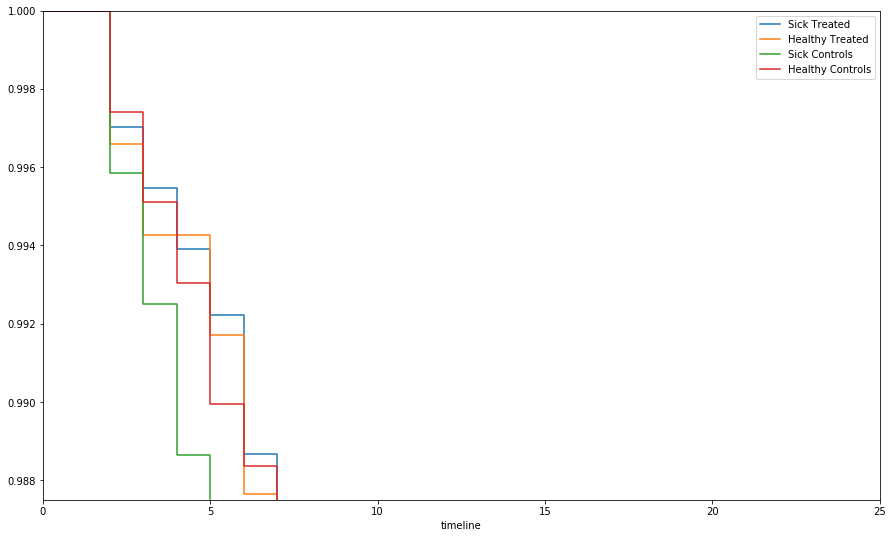

In [12]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

kmf = KaplanMeierFitter()

kmf.fit(surv1['T'], event_observed=surv1.E, label="Sick Treated")
kmf.plot_survival_function(ax=ax,ci_show=False)

kmf.fit(surv2['T'], event_observed=surv2.E, label="Healthy Treated")
kmf.plot_survival_function(ax=ax,ci_show=False)

kmf.fit(surv3['T'], event_observed=surv3.E, label="Sick Controls")
kmf.plot_survival_function(ax=ax,ci_show=False)

kmf.fit(surv4['T'], event_observed=surv4.E, label="Healthy Controls")
kmf.plot_survival_function(ax=ax,ci_show=False)

ax.set_xlim(0, 25)
ax.set_ylim(0.9875, 1)
fig.show()

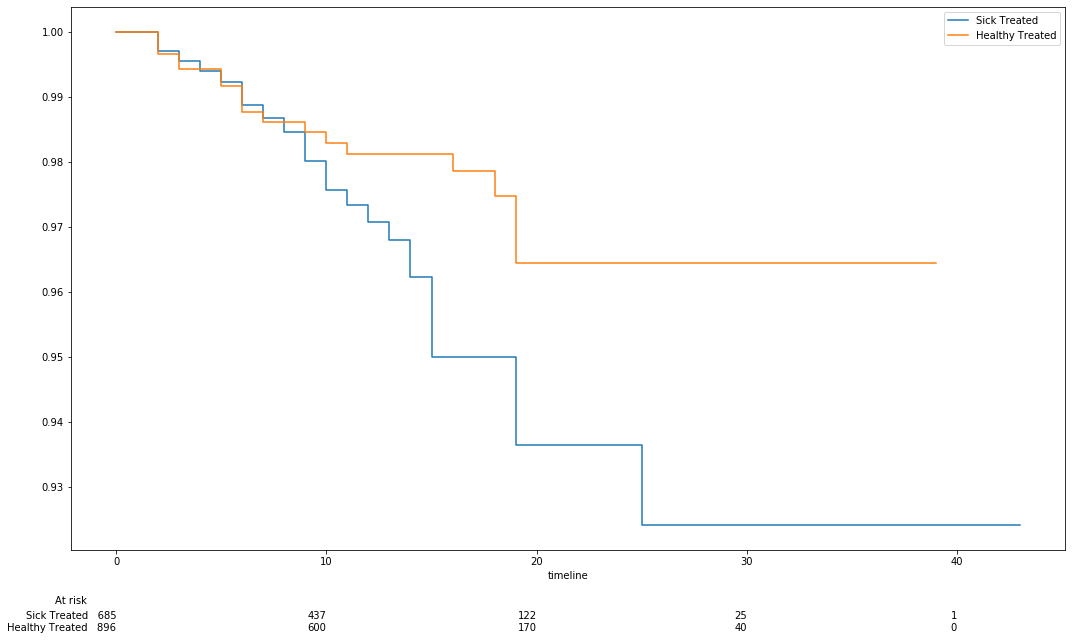

In [13]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

kmf1 = KaplanMeierFitter()

kmf1 = kmf1.fit(surv1['T'], event_observed=surv1.E, label="Sick Treated")
ax = kmf1.plot_survival_function(ax=ax,ci_show=False)

kmf2 = KaplanMeierFitter()

kmf2 = kmf2.fit(surv2['T'], event_observed=surv2.E, label="Healthy Treated")
ax = kmf2.plot_survival_function(ax=ax,ci_show=False)

add_at_risk_counts(kmf1, kmf2, ax=ax)


plt.tight_layout()

In [14]:
results = logrank_test(surv1['T'], surv2['T'], event_observed_A=surv1.E, event_observed_B=surv2.E)
results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
 test_statistic    p  -log2(p)
           4.28 0.04      4.70


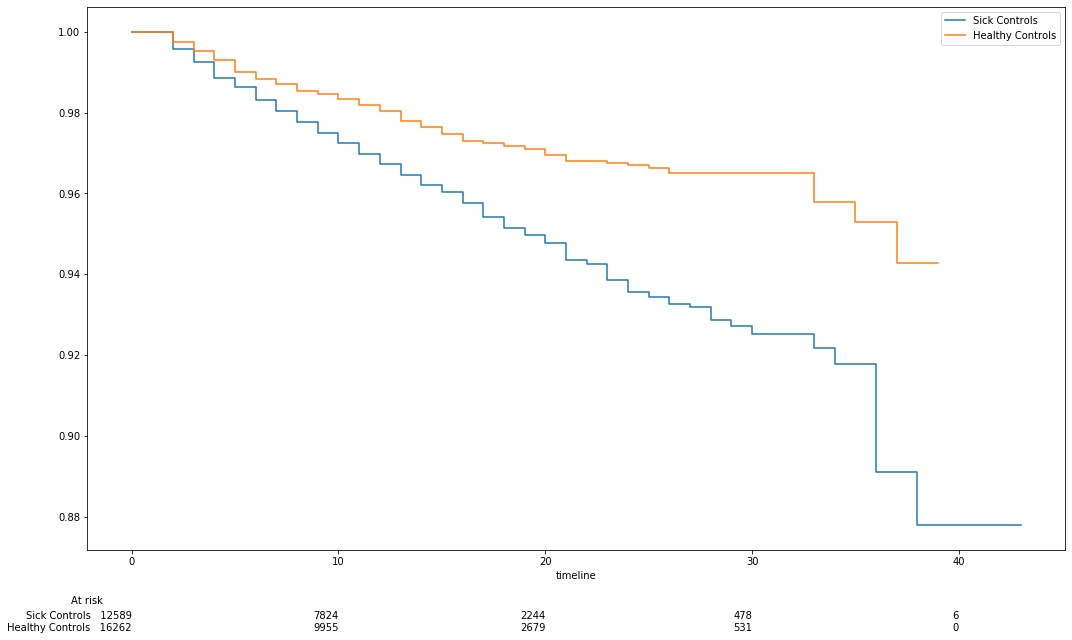

In [15]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

kmf1 = KaplanMeierFitter()

kmf1 = kmf1.fit(surv3['T'], event_observed=surv3.E, label="Sick Controls")
ax = kmf1.plot_survival_function(ax=ax,ci_show=False)

kmf2 = KaplanMeierFitter()

kmf2 = kmf2.fit(surv4['T'], event_observed=surv4.E, label="Healthy Controls")
ax = kmf2.plot_survival_function(ax=ax,ci_show=False)

add_at_risk_counts(kmf1, kmf2, ax=ax)


plt.tight_layout()

In [16]:
results = logrank_test(surv3['T'], surv4['T'], event_observed_A=surv3.E, event_observed_B=surv4.E)
results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
 test_statistic      p  -log2(p)
          57.65 <0.005     44.86


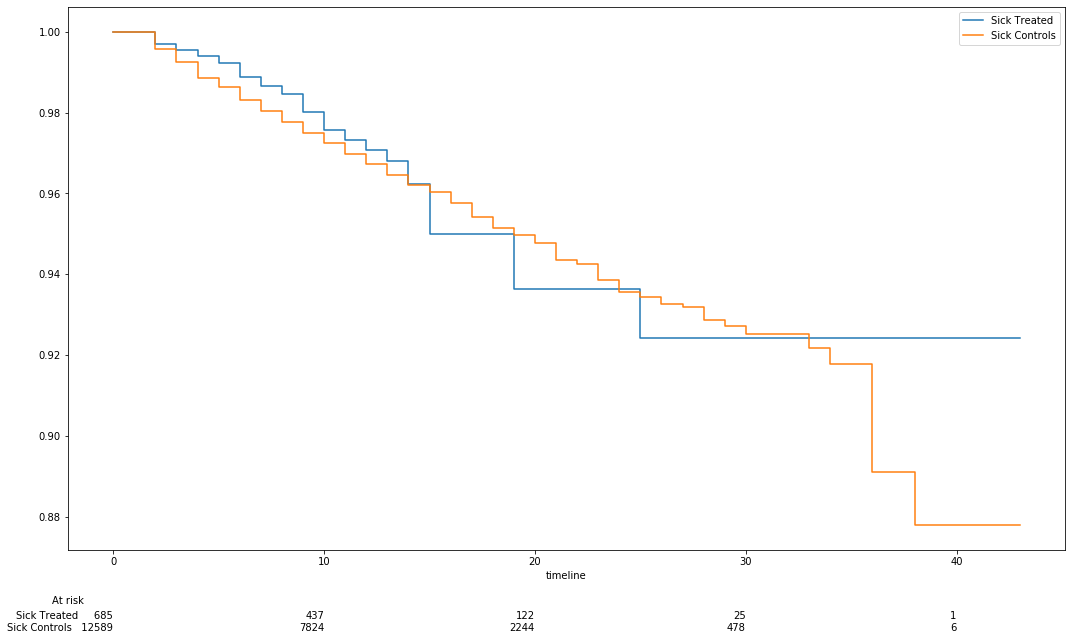

In [17]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

kmf1 = KaplanMeierFitter()

kmf1 = kmf1.fit(surv1['T'], event_observed=surv1.E, label="Sick Treated")
ax = kmf1.plot_survival_function(ax=ax,ci_show=False)

kmf2 = KaplanMeierFitter()

kmf2 = kmf2.fit(surv3['T'], event_observed=surv3.E, label="Sick Controls")
ax = kmf2.plot_survival_function(ax=ax,ci_show=False)

add_at_risk_counts(kmf1, kmf2, ax=ax)


plt.tight_layout()

In [18]:
results = logrank_test(surv1['T'], surv3['T'], event_observed_A=surv1.E, event_observed_B=surv3.E)
results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
 test_statistic    p  -log2(p)
           0.00 1.00      0.00


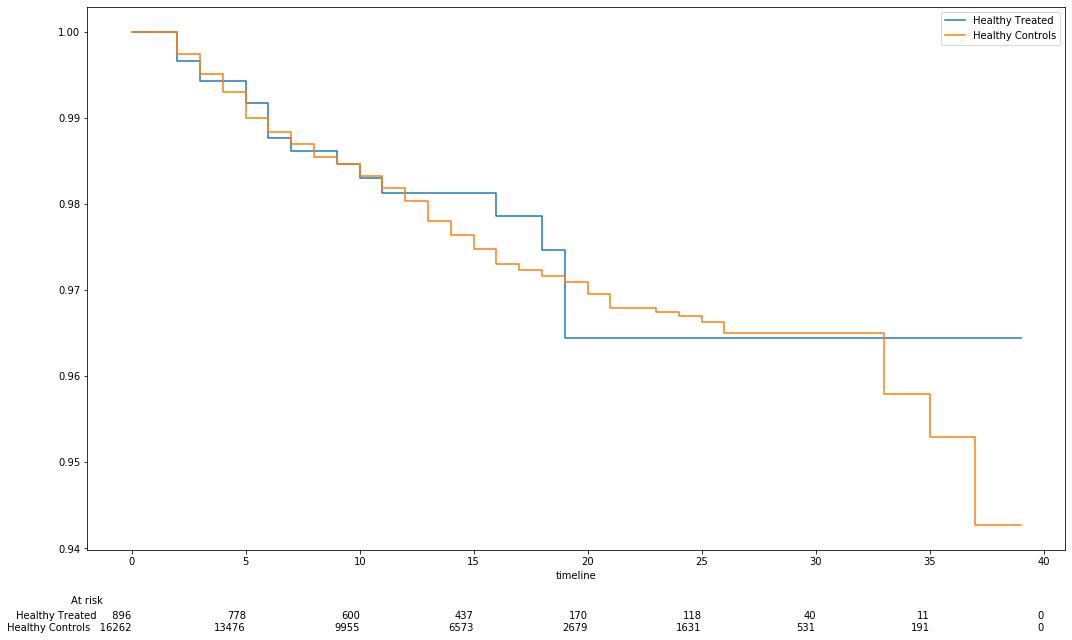

In [19]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

kmf1 = KaplanMeierFitter()

kmf1 = kmf1.fit(surv2['T'], event_observed=surv2.E, label="Healthy Treated")
ax = kmf1.plot_survival_function(ax=ax,ci_show=False)

kmf2 = KaplanMeierFitter()

kmf2 = kmf2.fit(surv4['T'], event_observed=surv4.E, label="Healthy Controls")
ax = kmf2.plot_survival_function(ax=ax,ci_show=False)

add_at_risk_counts(kmf1, kmf2, ax=ax)


plt.tight_layout()

In [20]:
results = logrank_test(surv2['T'], surv4['T'], event_observed_A=surv2.E, event_observed_B=surv4.E)
results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
 test_statistic    p  -log2(p)
           0.10 0.75      0.41


### Cox Proportional Hazards Model: Models the hazard function $h(t|x)$ -  <br/> 
Doesn't work: gets error "ConvergenceError: delta contains nan value(s). Convergence halted" 

$h(t|x) = h_0(t)f(x)$
where $h_0$ is the baseline hazard function depending only on time $t$
and $f(x)$ modifies the hazard function dependent on a subject's covariates

In [27]:
from sklearn.preprocessing import MinMaxScaler

columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR', 'CC_CHRONIC_KIDNEY', 'CC_HEART_FAILURE', 'CC_ISCHEMIC', 'CC_STROKE', 'CC_HYPERLIPIDEMIA', 
                    'CC_HYPERTENSION', 'CC_DX_CNT', 'T', 'E']


surv11 = surv1.loc[:,columns_to_match].dropna()
surv21 = surv2.loc[:,columns_to_match].dropna()
surv31 = surv3.loc[:,columns_to_match].dropna()
surv41 = surv4.loc[:,columns_to_match].dropna()

columns_to_normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']
surv11[columns_to_normalize] = MinMaxScaler().fit_transform(surv11[columns_to_normalize].values)
surv21[columns_to_normalize] = MinMaxScaler().fit_transform(surv21[columns_to_normalize].values)
surv31[columns_to_normalize] = MinMaxScaler().fit_transform(surv31[columns_to_normalize].values)
surv41[columns_to_normalize] = MinMaxScaler().fit_transform(surv41[columns_to_normalize].values)

cpx1 = CoxPHFitter().fit(surv11, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)
#cpx2 = CoxPHFitter().fit( surv21, duration_col = 'T', event_col = 'E', step_size = 0.1,show_progress=True)

cpx3 = CoxPHFitter().fit(surv31, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)
#cpx4 = CoxPHFitter().fit(surv41, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)

Iteration 25: norm_delta = 0.10064, step_size = 1.0000, ll = -143.17590, newton_decrement = 0.00000, seconds_since_start = 0.1Convergence completed after 25 iterations.
Iteration 17: norm_delta = 0.00000, step_size = 1.0000, ll = -3955.65270, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 17 iterations.


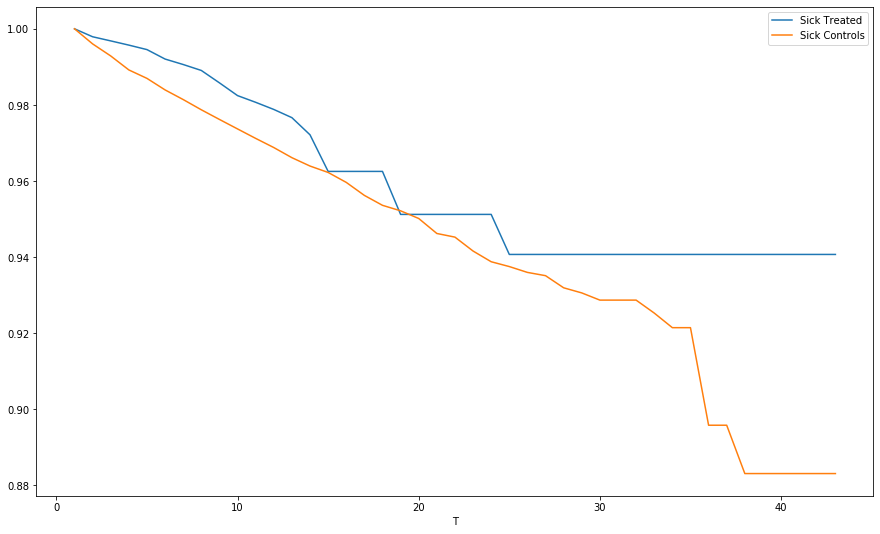

In [22]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

ax = cpx1.baseline_survival_.plot(ax = ax)
cpx3.baseline_survival_.plot(ax = ax)
#cpx4.baseline_survival_.plot(ax = ax)
ax.legend(['Sick Treated', 'Sick Controls', 'Healthy Controls'])
plt.show()

### Coefficient Plot

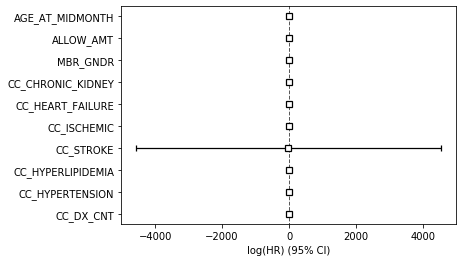

In [28]:
cols = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR', 'CC_CHRONIC_KIDNEY', 'CC_HEART_FAILURE', 
        'CC_ISCHEMIC', 'CC_STROKE', 'CC_HYPERLIPIDEMIA', 'CC_HYPERTENSION', 'CC_DX_CNT']

cpx1.plot(columns = cols)
plt.show()

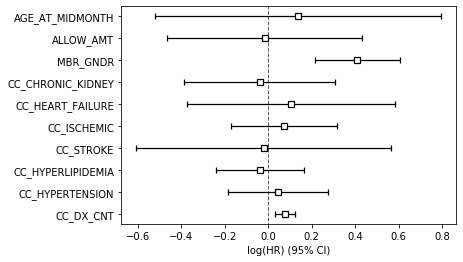

In [24]:
cpx3.plot(columns=cols)
plt.show()

In [25]:
# cpx4.plot(columns = cols)
# plt.show()